# Chapter 7: Ensemble Learning and Random Forests

## 1. Voting Classifier Introduction

In [1]:
# Libraries

import numpy as np
import pandas as pd

np.random.seed(42)

# Plots

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 1.1 Law of Large Numbers Simulation

In [2]:
# Consider a weighted coin...

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) # flip 10 coins 10k times
cumulative_heads_ratio = np.cumsum(coin_tosses, axis = 0)/np.arange(1, 10001).reshape(-1, 1)

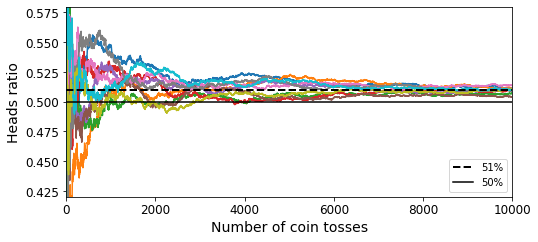

In [4]:
# Plot the results

plt.figure(figsize = (8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth = 2, label = "51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label = "50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc = "lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

### 1.2 Power of Voting Classifier - Example

In [12]:
# Use moons dataset as an example

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 500, noise = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Base models
log_clf = LogisticRegression(solver = "lbfgs", random_state = 42)
rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
svm_clf = SVC(gamma = "scale", random_state = 42)

# Do voting classification among these models!
voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'hard')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [14]:
# Check performance on the test set

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [22]:
# Try soft voting instead

svm_clf = SVC(gamma = "scale", random_state = 42, probability = True)

soft_voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting = 'soft')

soft_voting_clf.fit(X_train, y_train)

y_pred = soft_voting_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.92

__Notes__ :
   - _Hard voting_ does vote over class outputs
   - _Soft voting_ gives more weight to more confident votes!
       - Need `voting = "soft"` and ensure that all classifiers estimate class probabilities

## 2. Bagging and Pasting

- __Bagging__ : resample training data _with_ replacement

- __Pasting__ : resample data _without_ replacement

### 2.1 Bagging Decision Trees

In [23]:
# Try bagged tree on the moons dataset

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state = 42),
    n_estimators = 500, max_samples = 100, bootstrap = True, random_state = 42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.904

In [26]:
# Contrast with simple tree classifier

tree_clf = DecisionTreeClassifier(random_state = 42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred_tree)

0.856

In [27]:
# Plot the performance gain from baggging

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

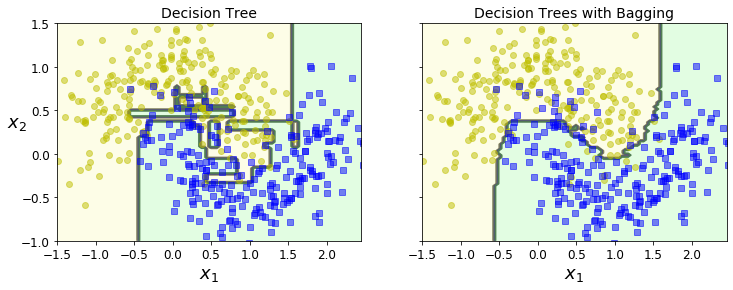

In [29]:
fix, axes = plt.subplots(ncols=2, figsize=(12,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### 2.2 OOB Error

In [32]:
# Train using OOB

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state = 42),
    n_estimators = 500, bootstrap = True, random_state = 42, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [33]:
bag_clf.oob_decision_function_[:10, ]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539]])

In [34]:
# Check accuracy difference by using OOB

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred) # marginally better than before

0.92

## 3. Random Forests

### 3.1 Example RF Models

#### 3.1.1 Moons dataset and bagging/rf relationship

In [35]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_pred_rf, y_test)

0.92

__Notes__ :
   - Random forest has all hyperparameters of `DecisionTreeClassifier` plus all from `BaggingClassifier`
   - Relationship between bagging & rf

In [36]:
# Can essentially implement rf from BaggingClassifier model

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

bag_clf.fit(X_train, y_train)
y_pred_bag_rf = bag_clf.predict(X_test)
accuracy_score(y_pred_bag_rf, y_test)

0.904

In [37]:
np.sum(y_pred_bag_rf == y_pred_rf)/len(y_pred_rf) # almost perfect agreement

0.984

#### 3.1.2 Iris dataset

In [38]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, random_state = 42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [39]:
rnd_clf.feature_importances_ # the same feature importances as above

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

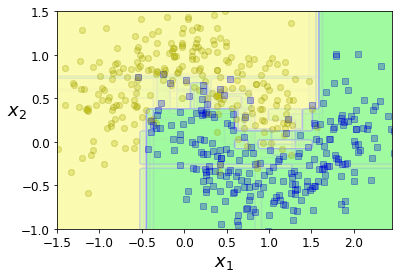

In [40]:
# Plot the rf results

plt.figure(figsize = (6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

### 3.2 Feature Importance

`sklearn` feature importance : how much the tree nodes that use a given feature reduce impurity on average across all trees in the forest

In [42]:
# Example - plot feature importance of each pixel on MNIST dataset!

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.target = mnist.target.astype(np.uint8)

In [43]:
# Fit random forest on the MNIST dataset

rnd_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [44]:
# Function to plot the feature importances

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation = "nearest")
    plt.axis("off")

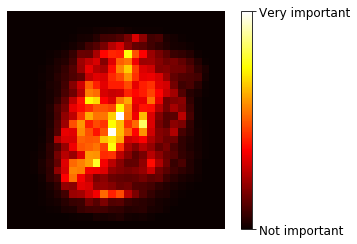

In [45]:
# Make the plot

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## 4. Boosting

### 4.1 AdaBoost

__Adaboost__ :
   1. Fit base learner
   2. Increase relative weight of misclassified training examples, modulated by learning rate
   3. Train second classifier using updated weights, makes another set of predictions, updates weights ...

#### 4.1.1 Fit basic AdaBoost model

In [46]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1),
    n_estimators = 200, algorithm = "SAMME.R", learning_rate = 0.5, random_state = 42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

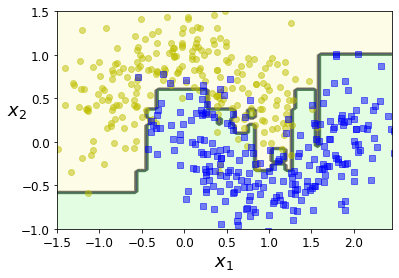

In [47]:
plot_decision_boundary(ada_clf, X, y)

In [48]:
ada_preds = ada_clf.predict(X_test)
accuracy_score(ada_preds, y_test)

0.896

#### 4.1.2 Effect of AdaBoost learning rate

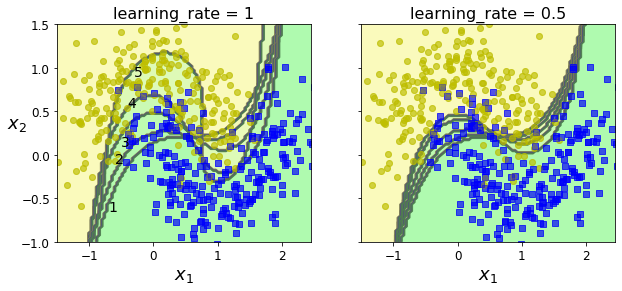

In [49]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

In [50]:
# Adaboost hyperparameters

list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

### 4.2 Gradient Boosting

#### 4.2.1 Iterative tree fitting on residuals

In [56]:
# Sample data

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [57]:
# Fit first tree

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [58]:
# Fit second tree on the residuals of the first

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [59]:
# Same for the third tree

y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2, random_state = 42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [60]:
# Check the predictions

X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [61]:
# Function to plot the predictions

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

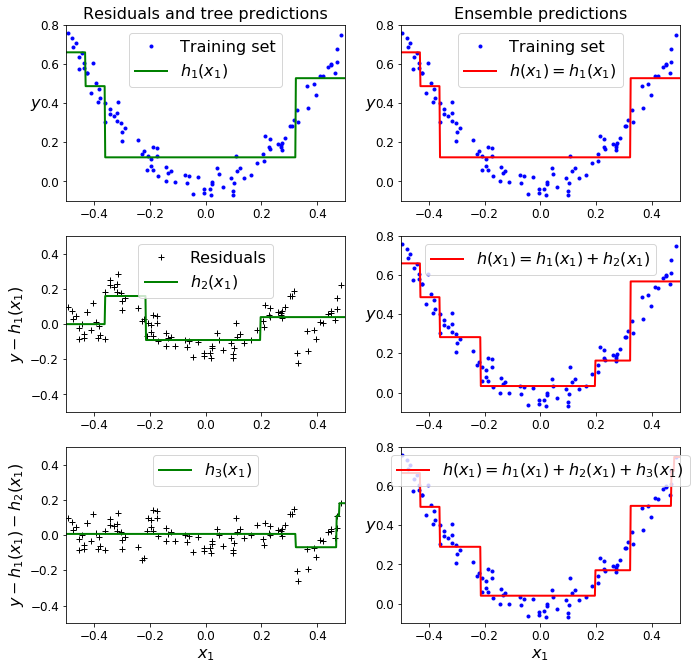

In [62]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

#### 4.2.2 Do the above procedure again with sklearn

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

gbrt.predict(X_new)

array([0.75026781])

#### 4.2.3 Better gbm with learning rate and hyperparameters

In [65]:
gbrt_slow = GradientBoostingRegressor(max_depth = 2, n_estimators = 200, learning_rate = 0.1, random_state = 42)
gbrt_slow.fit(X, y)

gbrt_slow.predict(X_new)

array([0.74398943])

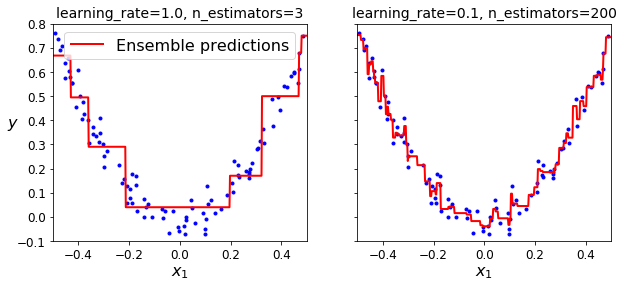

In [66]:
# Plot the results

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

### 4.3 Gradient Boosting with Early Stopping

#### 4.3.1 Method 1

- Can use `staged_predict()` built-in to GBM to return prediction at each step

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Train, val split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 49)

# Fit the model
gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120, random_state = 42)
gbrt.fit(X_train, y_train)

# Look at the val errors
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators, random_state = 42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [69]:
min_error = np.min(errors)
min_error

0.002712853325235463

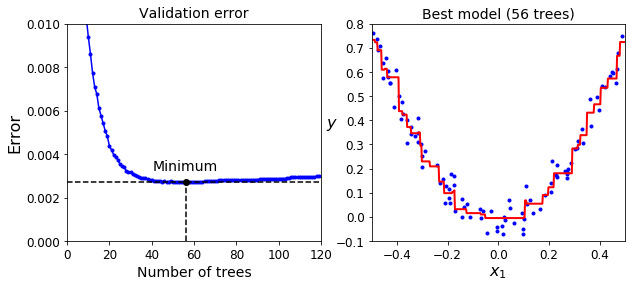

In [70]:
# Early stopping results

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

#### 4.3.2 Method 2

- Alternatively, can set `warm_start = True` to keep existing trees when `fit()` called
- Stop when val error doesn't improve for certain number of iterations in a row

In [71]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [72]:
print(gbrt.n_estimators)

61


In [73]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


### 4.4 XGBoost

In [75]:
try:
    import xgboost
except ImportError as ex:
    print("Error: xgboost not installed")
    xgboost = None

In [76]:
# Train the model

xgb_reg = xgboost.XGBRegressor(random_state = 42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Val MSE:", val_error)

Val MSE: 0.00400040950714611


In [77]:
# With early stopping

xgb_reg = xgboost.XGBRegressor(random_state = 42)
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Val MSE:", val_error)

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Val MSE: 0.0026308690413069744
